In [117]:
import numpy as np
import matplotlib.pyplot as plt
import LCPSolve
import assignment_3_render

In [118]:
# DEFINE GLOBAL PARAMETERS
L = 0.4
MU = 0.3
EP = 0.5
dt = 0.01
m = 0.3
g = np.array([0., -9.81, 0.])
rg = 1./12. * (2 * L * L)
M = np.array([[m, 0, 0], [0, m, 0], [0, 0, m * rg]])
Mi = np.array([[1./m, 0, 0], [0, 1./m, 0], [0, 0, 1./(m * rg)]])
DELTA = 0.001
T = 150

In [119]:
def get_contacts(q):
    """
        Return jacobian of the lowest corner of the square and distance to contact
        :param q: <np.array> current configuration of the object
        :return: <np.array>, <float> jacobian and distance
    """
    # ------------------------------------------------
    # FILL WITH YOUR CODE
    x = q[0]
    y = q[1]
    theta = np.radians((q[2]*180/np.pi)%90)
    ny = 1
    nx = 0

    rx = -L/2*np.sqrt(2)*np.sin(np.pi/4-theta) 
    ry = -L/2*np.sqrt(2)*np.cos(np.pi/4-theta)
    phi = y - (np.sqrt(2)/2*L*np.cos(np.pi/4-theta))

    Jt = np.array([ny,-nx,-ry])
    Jn = np.array([nx,ny,rx])
    J = np.array([Jt,Jn])
    jac = np.transpose(J)
    # ------------------------------------------------
    return jac, phi
# test
q0 = np.array([0.0, 1.5, np.pi / 180. * 30.])
jac,p = get_contacts(q0)
print(jac,"\n",p)

[[ 1.          0.        ]
 [ 0.          1.        ]
 [ 0.27320508 -0.07320508]] 
 1.2267949192431122


In [120]:
def form_lcp(jac, v):
    """
        Return LCP matrix and vector for the contact
        :param jac: <np.array> jacobian of the contact point
        :param v: <np.array> velocity of the center of mass
        :return: <np.array>, <np.array> V and p
    """
    # ------------------------------------------------
    # FILL WITH YOUR CODE
    Jn = jac[:,1]
    Jt = jac[:,0]
    Jhat = np.transpose(np.array([Jn,-Jt,Jt]))

    V_ = np.matmul(np.matmul(np.transpose(Jhat),np.linalg.inv(M)),Jhat)*dt
    V = np.zeros((4,4))
    V[0,0] = Jn@np.linalg.inv(M)@Jn.reshape((3,1))*dt 
    V[0,1] = -Jn@np.linalg.inv(M)@Jt.reshape((3,1))*dt 
    V[0,2] = Jn@np.linalg.inv(M)@Jt.reshape((3,1))*dt 

    V[1,0] = -Jt@np.linalg.inv(M)@Jn.reshape((3,1))*dt 
    V[1,1] = Jt@np.linalg.inv(M)@Jt.reshape((3,1))*dt 
    V[1,2] = -Jt@np.linalg.inv(M)@Jt.reshape((3,1))*dt 

    V[2,0] = Jt@np.linalg.inv(M)@Jn.reshape((3,1))*dt 
    V[2,1] = -Jt@np.linalg.inv(M)@Jt.reshape((3,1))*dt 
    V[2,2] = Jt@np.linalg.inv(M)@Jt.reshape((3,1))*dt 

    V[-1,:] = [MU,-1,-1,0]
    V[1,-1] = 1
    V[2,-1] = 1

    fe = (m*g).reshape((3,1))
    p = np.zeros((4,))
    p[0] = np.matmul(Jn,((1+EP)*v.reshape((3,1))+np.matmul(dt*np.linalg.inv(M),fe)))
    p[1] = np.matmul((0-Jt),(v.reshape((3,1))+np.matmul(dt*np.linalg.inv(M),fe)))
    p[2] = np.matmul(Jt,(v.reshape((3,1))+np.matmul(dt*np.linalg.inv(M),fe)))
    p[3] = 0
    # ------------------------------------------------
    return V, p
# test
v0 = np.array([0., -0.2, 0.])
V,p = form_lcp(jac,v0)
print(V,"\n",p)

[[ 0.04003206  0.025      -0.025       0.        ]
 [ 0.025       0.1266346  -0.1266346   1.        ]
 [-0.025      -0.1266346   0.1266346   1.        ]
 [ 0.3        -1.         -1.          0.        ]] 
 [-0.3981  0.      0.      0.    ]


In [121]:
def lcp_solve(V, p):
    """
        DO NOT CHANGE -- solves the LCP
        :param V: <np.array> matrix of the LCP
        :param p: <np.array> vector of the LCP
        :return: renders the trajectory
    """
    sol = LCPSolve.LCPSolve(V, p)
    f_r = sol[1][:3]
    return f_r

In [122]:
def step(q, v):
    """
        predict next config and velocity given the current values
        :param q: <np.array> current configuration of the object
        :param v: <np.array> current velocity of the object
        :return: <np.array>, <np.array> q_next and v_next
    """
    # ------------------------------------------------
    # FILL WITH YOUR CODE
    jac,phi = get_contacts(q)
    Jt = jac[:,0]
    Jn = jac[:,1]
    V,p = form_lcp(jac,v)
    fc = lcp_solve(V,p)
    fn = fc[0]
    ft1 = fc[1]
    ft2 = fc[2]
    fe = m*g
    qp = np.array([0,DELTA,0])
    if phi > DELTA:
        v_next = v + np.matmul(dt * np.linalg.inv(M), fe)
        q_next = q + dt * v_next 
    else:
        v_next = v + np.matmul(dt*np.linalg.inv(M),(fe+Jn*fn-Jt*ft1+Jt*ft2))
        q_next = q + dt*v_next + qp
    # ------------------------------------------------
    return q_next, v_next
# test
q_,v_ = step(q0,v0)
print(q_)
print(v_)

[0.         1.497019   0.52359878]
[ 0.     -0.2981  0.    ]


In [123]:
def simulate(q0, v0):
    """
        predict next config and velocity given the current values
        :param q0: <np.array> initial configuration of the object
        :param v0: <np.array> initial velocity of the object
        :return: <np.array>, <np.array> q and v trajectory of the object
    """
    # ------------------------------------------------
    # FILL WITH YOUR CODE

    q = np.zeros((3, T))  # TODO: Replace with your result
    v = np.zeros((3, T))

    for idx in range(T):
        if idx == 0:
            q[:,idx] = q0
            v[:,idx] = v0
        else:
            Q,V = step(q[:,idx-1],v[:,idx-1])
            q[:,idx] = Q
            v[:,idx] = V
    # ------------------------------------------------
    return q, v

In [124]:
def render(q):
    """
        DO NOT CHANGE -- renders the trajectory
        :param q: <np.array> configuration trajectory
        :return: renders the trajectory
    """
    assignment_3_render.render(q)

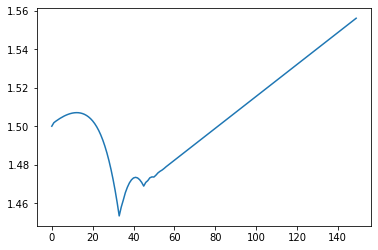

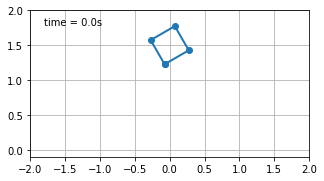

In [116]:
if __name__ == "__main__":
    # to test your final code, use the following initial configs
    q0 = np.array([0.0, 1.5, np.pi / 180. * 30.])
    v0 = np.array([0., -0.2, 0.])
    q, v = simulate(q0, v0)

    plt.plot(q[1, :])
    plt.show()

    render(q)